# Flinks data challenge

The objective of the challenge was to classify each project in its right main_category given the name and basic informaiton of the project

This notebook consists of 4 sections in following order:

1. Data preprocessing

2. Exploratory analysis

3. Best results

4. Other modeling attempts

Results: 

2 embedding techniques and 4 models were chosen to carry out the classification. All models were able to deliver at least 95% scores for overall precision and recall using project name & sub-catgory as predictors and undersampling technique. Among all models, LinearSVC and Logistic Regression had the highest accurracy (99%). Naive Bayes had the fastest computation time (1.68s) with a 96% accuracy

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

import string
punct = list(set(string.punctuation))

from html.parser import HTMLParser

import gensim
from gensim import corpora
from gensim import models
from gensim.models import Phrases, Word2Vec
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense, corpus2csc

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [90]:
path = '/content/gdrive/My Drive/Colab Notebooks/data/flinks-data-challenge.csv'

df = pd.read_csv(path)
df.drop('Unnamed: 0',axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preprocessing 

This section consists of basic data cleaning for each column

#### name

The first step was to check if there was any missing value, and 4 missing titles were found after initial screening. Since they only made up of 0.0012% of the dataset, I decided to simply drop them becauseit would not affect much for the result later on

In [42]:
print(df.isna().sum()/len(df)*100)
df[df['name'].isna()]

name             0.001238
goal             0.000000
sub_category     0.000000
main_category    0.000000
launched         0.000000
deadline         0.000000
dtype: float64


,name,goal,sub_category,main_category,launched,deadline
142581,NaN,200000,Narrative Film,Film & Video,2012-01-01 12:35:31,2012-02-29 15:04:00
262398,NaN,2000,Video Games,Games,2012-12-19 23:57:48,2013-01-06 23:00:00
264745,NaN,2500,Product Design,Design,2016-06-18 05:01:47,2016-07-18 05:01:47
289292,NaN,35000,Painting,Art,2011-11-06 23:55:55,2011-12-05 05:59:00


In [43]:
df.dropna(subset=['name'],axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

The second step was to clean up the name of projects. Having examined several samples, the following rules were applied to process all the project names.

- It was found that some projects across multiple categoires had either (Canceled) or (Suspended) in thier name to indicate the cancelation/suspension of that project. Since these two terms were intuitively irrelavent to the category, so I decided to remove them.

- Some projects had a / between two words, so I decided to replace it with 'or' to indicate its semantic meaning. Otherwise its significance would vanish after the punctuation removal step

- Besides the common punctuations, some punctuations seemed to have different encoding, so they wered added to the punctuation list manually 

- As for the number in title, the value of the number would be less important than the fact that there was a number in the title, so I decided to replace all numbers with %d to avoid generating too many vocab of number, hence decreasing memory usage.

- Similar to the idea of number replacement, the presence of a url was more important than the identity of url itself, so I replaced all web links with a word 'url' to indicate its presence

- There were also quite a few special characters in the title, so I decided to remove them to reduce the noise

- A lot of titles had words in uppercase, but the meaning of them would be identical if in lowercase, so I decided to lowercase all the words to avoid generating the same vocab with one in lowercase and one in uppercase

- Because stopwords (e.g. a, and, the, ...) would introduce noise to the data, so they were also removed. It was found that some titles were in German, so the stopwords set included English and German

- after removing the stopwords, it was found that some titles had a pattern of [ stopword + 's ], which is not in the set of stopwrods. Thus, I decided to remove the remaining 's .

- Finally, some titles would have two whitespace after the above cleaning, so I reduced the two whitespace to one 

In [25]:
stop_words = set(stopwords.words(['english','german']))

# the following punctuations were in different encoding, so they had to be added to the list 
punct.append('``')
punct.append('\'\'')
punct.append('\'')
punct.append('...')
punct.append('||')

def title_cleaning(name):
  # remove the word (Canceled) and (Suspended)
  name = ' '.join([word for word in name.split() if not word in ['(Canceled)','(Suspended)']]) 

  # replace / with or to indicate the semantic meaning 
  name = re.sub('/',' or ',name)

  # remove punctuation 
  name = ' '.join(word for word in word_tokenize(name) if word not in punct)

  # replace all number with %d to unify the signifiance of the word 
  name = ' '.join("%d" if word.isdigit() else word for word in name.split())

  # replace all web links with url to unify the signifiance of the weblink 
  name = re.sub(r'www.*.com', "url", name)
  
  # remove special characters
  name = re.sub(r'(?:[\ufffd]+)','',name)
  
  # lowercase the word
  name = name.lower()
  
  # remove stop words
  name = ' '.join([word for word in name.split() if not word in stop_words])
  
  # replace any 's if it's missed from stop wods removal 
  name = re.sub('\'s', '', name)
  
  # replace double white space with single white space
  name = re.sub('  ',' ',name)

  return name

In [44]:
df['processed_name'] = df['name'].apply(lambda x: title_cleaning(x))

#### goal

The first step was to convert the column to numerice type, and replace the non-numeric value with NaN using the parameter errors = 'coerce'

In [45]:
df['goal']= df['goal'].apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [46]:
print(df.isna().sum())
df[df['goal'].isna()]

name              0
goal              7
sub_category      0
main_category     0
launched          0
deadline          0
processed_name    0
dtype: int64


,name,goal,sub_category,main_category,launched,deadline,processed_name
64370,CD: Heartsong Harmonics,NaN,Marc & Mary sing together at last!,Music,7085,USD,cd heartsong harmonics
85465,Everyday Beautiful,NaN,a day in the life of a champion,Film & Video,2000,USD,everyday beautiful
98438,Hana Zara's new album,NaN,The North (2015),Music,3000,USD,hana zara new album
123282,Celebrating Joni Mitchell,NaN,Songs by & about her + Stories,Music,5000,CAD,celebrating joni mitchell
159138,Legal Highs,NaN,The Sobering Truth,Film & Video,5000,GBP,legal highs
162774,Puppy Training Steps,NaN,Right and Wrong,Film & Video,5000,USD,puppy training steps
177307,Adventure to Peru's Sacred Valley,NaN,Recording Soundtracks,Music,2200,USD,adventure peru sacred valley


For the NaN values in the column, the users seemed to input the value of goal in the column *launched* . Therefore, the easiest way to fix this issue was to fill the NaN with the values from the column *launched* 

In [47]:
df['goal'].fillna(df[df['goal'].isna()]['launched'].astype('float'),inplace=True)

#### launched and deadline

The first step was to convert both columns to datetime type and compute the duration of project

In [48]:
df['launched'] = df['launched'].apply(lambda x: pd.to_datetime(x, errors='coerce',yearfirst=True))
df['deadline'] = df['deadline'].apply(lambda x: pd.to_datetime(x, errors='coerce',yearfirst=True))

df['duration'] = df['deadline']-df['launched']
df['duration'] = df['duration'].apply(lambda x: x.days)

The sceond step was to examine the missing values in all three columns

In [49]:
print(df.isna().sum())
df[df['launched'].isna()]

name              0
goal              0
sub_category      0
main_category     0
launched          5
deadline          7
processed_name    0
duration          7
dtype: int64


,name,goal,sub_category,main_category,launched,deadline,processed_name,duration
64370,CD: Heartsong Harmonics,7085.0,Marc & Mary sing together at last!,Music,NaT,NaT,cd heartsong harmonics,NaN
98438,Hana Zara's new album,3000.0,The North (2015),Music,NaT,NaT,hana zara new album,NaN
123282,Celebrating Joni Mitchell,5000.0,Songs by & about her + Stories,Music,NaT,NaT,celebrating joni mitchell,NaN
159138,Legal Highs,5000.0,The Sobering Truth,Film & Video,NaT,NaT,legal highs,NaN
162774,Puppy Training Steps,5000.0,Right and Wrong,Film & Video,NaT,NaT,puppy training steps,NaN


In [50]:
df[df['deadline'].isna()]

,name,goal,sub_category,main_category,launched,deadline,processed_name,duration
64370,CD: Heartsong Harmonics,7085.0,Marc & Mary sing together at last!,Music,NaT,NaT,cd heartsong harmonics,NaN
85465,Everyday Beautiful,2000.0,a day in the life of a champion,Film & Video,2000-01-01,NaT,everyday beautiful,NaN
98438,Hana Zara's new album,3000.0,The North (2015),Music,NaT,NaT,hana zara new album,NaN
123282,Celebrating Joni Mitchell,5000.0,Songs by & about her + Stories,Music,NaT,NaT,celebrating joni mitchell,NaN
159138,Legal Highs,5000.0,The Sobering Truth,Film & Video,NaT,NaT,legal highs,NaN
162774,Puppy Training Steps,5000.0,Right and Wrong,Film & Video,NaT,NaT,puppy training steps,NaN
177307,Adventure to Peru's Sacred Valley,2200.0,Recording Soundtracks,Music,2200-01-01,NaT,adventure peru sacred valley,NaN


There were 7 projects with missing values in launched/dealine columns. 5 of them were missing both launched date and deadline date. One project seemed to have a typo in in the launched date. Instead of filling the values in these two columns, I decided to only fill their missing duration by using the average duration from their corresponding main category

Additionally, it was noticed that the values in the sub category in these projects seemed to be in the wrong column, which prompted for a cleaning on sub category

In [ ]:
# Examine the statistics of duration for each category
df.groupby('main_category')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
main_category,,,,,,,,
Art,23958.0,33.424785,96.585320,1.0,29.0,30.0,35.0,14835.0
Comics,8743.0,34.601739,12.291730,1.0,30.0,30.0,35.0,91.0
Crafts,7182.0,31.583821,11.120581,1.0,29.0,30.0,30.0,91.0
Dance,3372.0,32.856762,13.179159,1.0,27.0,30.0,36.0,91.0
Design,23864.0,35.056612,95.623765,1.0,30.0,30.0,40.0,14709.0
Fashion,18382.0,32.913829,10.996222,1.0,30.0,30.0,35.0,92.0
Film & Video,57661.0,35.721146,88.218412,1.0,30.0,30.0,40.0,14867.0
Food,21198.0,33.874516,12.028528,1.0,30.0,30.0,35.0,91.0
Games,28004.0,32.758285,10.833211,1.0,30.0,30.0,33.0,91.0


In [ ]:
# filling the missing duration by using the average duration of the project's category 

missing_val_idx = []
fillna_val = []

# extracting the index of data with missing duration value and assign the value to fill in a list
for cat in df[df['duration'].isna()]['main_category'].unique():
  missing_val_idx.append(df[(df['main_category']==cat) & (df['duration'].isna())].index)
  fillna_val.append(df[(df['main_category']==cat)]['duration'].mean())

# filling the missing values
for cat_idx,val in zip(missing_val_idx,fillna_val):
  for idx in cat_idx:
    df.iloc[idx,-1] = val

#### Sub category

The first step was to examine the number of abnormal sub categories in each category

In [54]:
for cat in df['main_category'].unique():
  print('main category: ', cat)
  print('')
  print('number of project in each sub-category: \n')
  print(df[df['main_category']==cat]['sub_category'].value_counts().sort_values(ascending = True))
  print('-----------------------------------')
  print('')

main category:  Publishing

number of project in each sub-category: 

Translations          127
Literary Journals     218
Calendars             243
Anthologies           266
Zines                 285
Young Adult           652
Academic              706
Radio & Podcasts      802
Periodicals          1142
Poetry               1220
Art Books            2224
Publishing           5050
Children's Books     5651
Nonfiction           7404
Fiction              8231
Name: sub_category, dtype: int64
-----------------------------------

main category:  Film & Video

number of project in each sub-category: 

 a day in the life of a champion        1
 Right and Wrong                        1
 The Sobering Truth                     1
Romance                               159
Movie Theaters                        194
Festivals                             228
Fantasy                               273
Family                                276
Experimental                          460
Music Videos        

Because there were not many outliers (less than 10 in total), so I decided to replace them with the most common sub category within the corresponding main category

In [55]:
sub_cat_rename_dict = dict()

for cat in df['main_category'].unique():
  sub_cat_mode =  df[df['main_category']==cat]['sub_category'].value_counts(ascending=False).index[0]

  for sub_cat in df[df['main_category']==cat]['sub_category'].unique():
    if len(df[(df['main_category']==cat) & (df['sub_category'] == sub_cat)].values) <10:
      sub_cat_rename_dict[sub_cat] = sub_cat_mode

df['processed_sub_category']= df['sub_category'].replace(sub_cat_rename_dict)

## Features Extraction and Exploratory analysis

#### Distribution of main category

Text(0.5, 1.0, 'main category distribution')

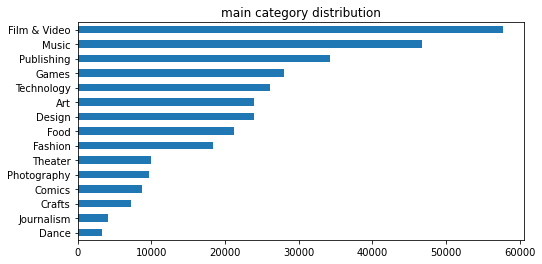

In [ ]:
plt.figure(figsize=(8,4))
df['main_category'].value_counts(ascending=True).plot(kind='barh')
plt.title('main category distribution')

**Observation:** It's is obvious that there is a class imbalance issue. The dominant categories outnumber the lowest amount category by more than 10 folds. A potential remedy for the issue is to perform re-sampling

#### Project Title name

There were 3 quantitative exploratory analyses for the project title names:

- number of word of each project title, 
- number of word with first letter in uppercase, 
- number of word in uppercase. 

If any of the above feature could help distinguish categories from one another, they could be incorporated into the predictors 

Additionally, it was noticed that some project titles were framed as a question, so it would be interesting to study if it was a preferred patten in certain categories 

In [ ]:
punct_no_question_mark = set(string.punctuation)
punct_no_question_mark.remove('?')

def is_question(name):
  num_question_sent = 0
  name = sent_tokenize(name.replace("\"",''))
  name = [sent for sent in name if len(sent) >1]
  for sent in name:
    sent = ' '.join(word for word in word_tokenize(sent) if word not in punct_no_question_mark)
    if( len(sent) > 0) and (sent[-1] == '?'):
      num_question_sent +=1
    
    if num_question_sent>0:
      return True
    else:
      return False

In [ ]:
df['num_word']= df['name'].apply(lambda x: len(word_tokenize(x)))
df['num_1st_letter_uppercase'] = df['name'].apply(lambda x: sum(word[0].isupper() for word in word_tokenize(x)))
df['num_capword'] = df['name'].apply(lambda x: sum(word.isupper() for word in word_tokenize(x)))
df['name_is_question'] = df['name'].apply(lambda x: is_question(x))

Text(0.5, 1.0, 'statics of project name in each main category')

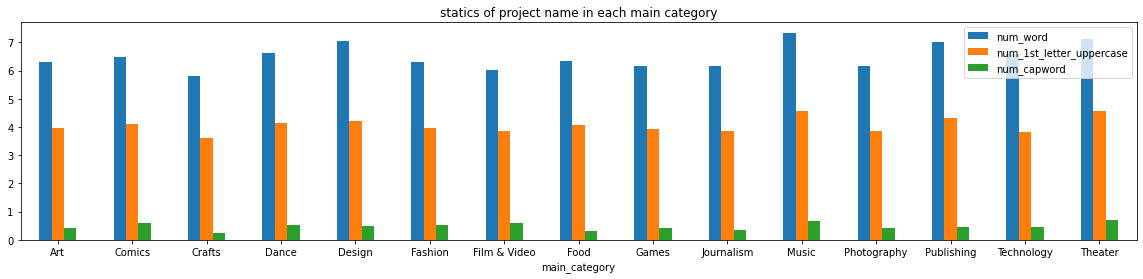

In [ ]:
fig= plt.figure(figsize=(20,4))
ax = fig.add_subplot(111)
df.groupby('main_category')[['num_word','num_1st_letter_uppercase','num_capword']].mean().plot(kind='bar',ax=ax)
plt.xticks(rotation=360)
plt.title('statics of project name in each main category')

**Observation:** All categories were similar in 3 quantitative aspects, so these aspects did not seem to be indicative for classification

Text(0.5, 1.0, 'number of project with a question sense in each main category')

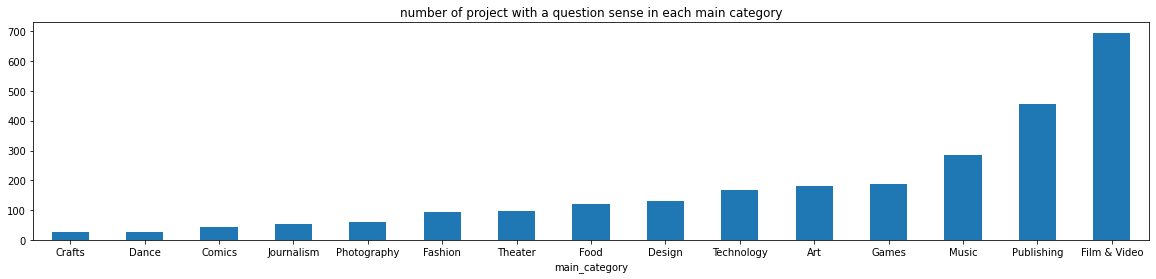

In [ ]:
##df['name_is_question'] = df['name_is_question'].map({True:int(1),False:int(0)}).astype('category')

fig= plt.figure(figsize=(20,4))
ax = fig.add_subplot(111)

df.groupby('main_category')['name_is_question'].sum().sort_values().plot(kind='bar',ax=ax)
plt.xticks(rotation=360)
plt.title('number of project with a question sense in each main category')

**Observation**: The Film & Video, Publishing, and Music categories had relatively more projects with a question sense than the rest of the categories. However, the highest number was still only around 700, it might not be very helpful to use indicator as  one of the predictors 

#### Project goal

In [ ]:
df.groupby('main_category')['goal'].describe()

,count,mean,std,min,25%,50%,75%,max
main_category,,,,,,,,
Art,23958.0,36413.842416,1.181711e+06,0.01,1000.000,3000.0,7500.00,100000000.0
Comics,8743.0,22910.229817,1.080410e+06,1.00,1500.000,3840.0,8475.00,100000000.0
Crafts,7182.0,11710.819618,1.300150e+05,1.00,644.125,2000.0,6500.00,10000000.0
Dance,3372.0,9719.983778,5.585464e+04,5.00,1500.000,3000.0,6400.00,2000000.0
Design,23864.0,49202.222047,1.008286e+06,1.00,4118.000,10000.0,30000.00,100000000.0
Fashion,18382.0,24751.340162,7.605822e+05,1.00,2000.000,6000.0,15000.00,100000000.0
Film & Video,57664.0,72986.051066,1.463831e+06,0.15,2500.000,6500.0,20000.00,100000000.0
Food,21198.0,50572.268969,1.027043e+06,1.00,3500.000,10000.0,25000.00,100000000.0
Games,28004.0,55624.263327,1.143162e+06,1.00,2800.000,8706.0,24711.25,100000000.0


Text(0.5, 1.0, 'distribution of poject goal per main category')

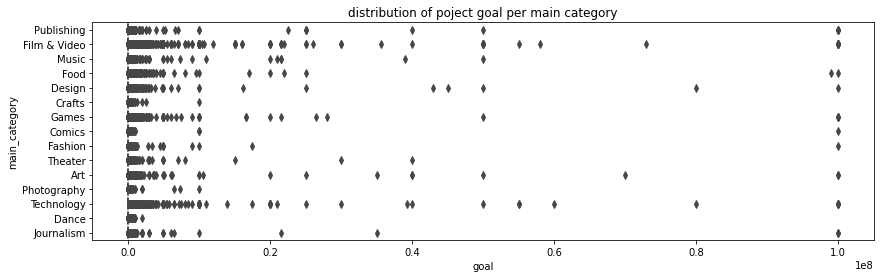

In [ ]:
plt.figure(figsize=(14,4))
sns.boxplot(x='goal',y='main_category',data=df,orient='h')
plt.title('distribution of poject goal per main category')

**Observation**: the boxplot above showed that there were quite a few extreme outliers, so this feature required further processing

<Figure size 576x288 with 0 Axes>

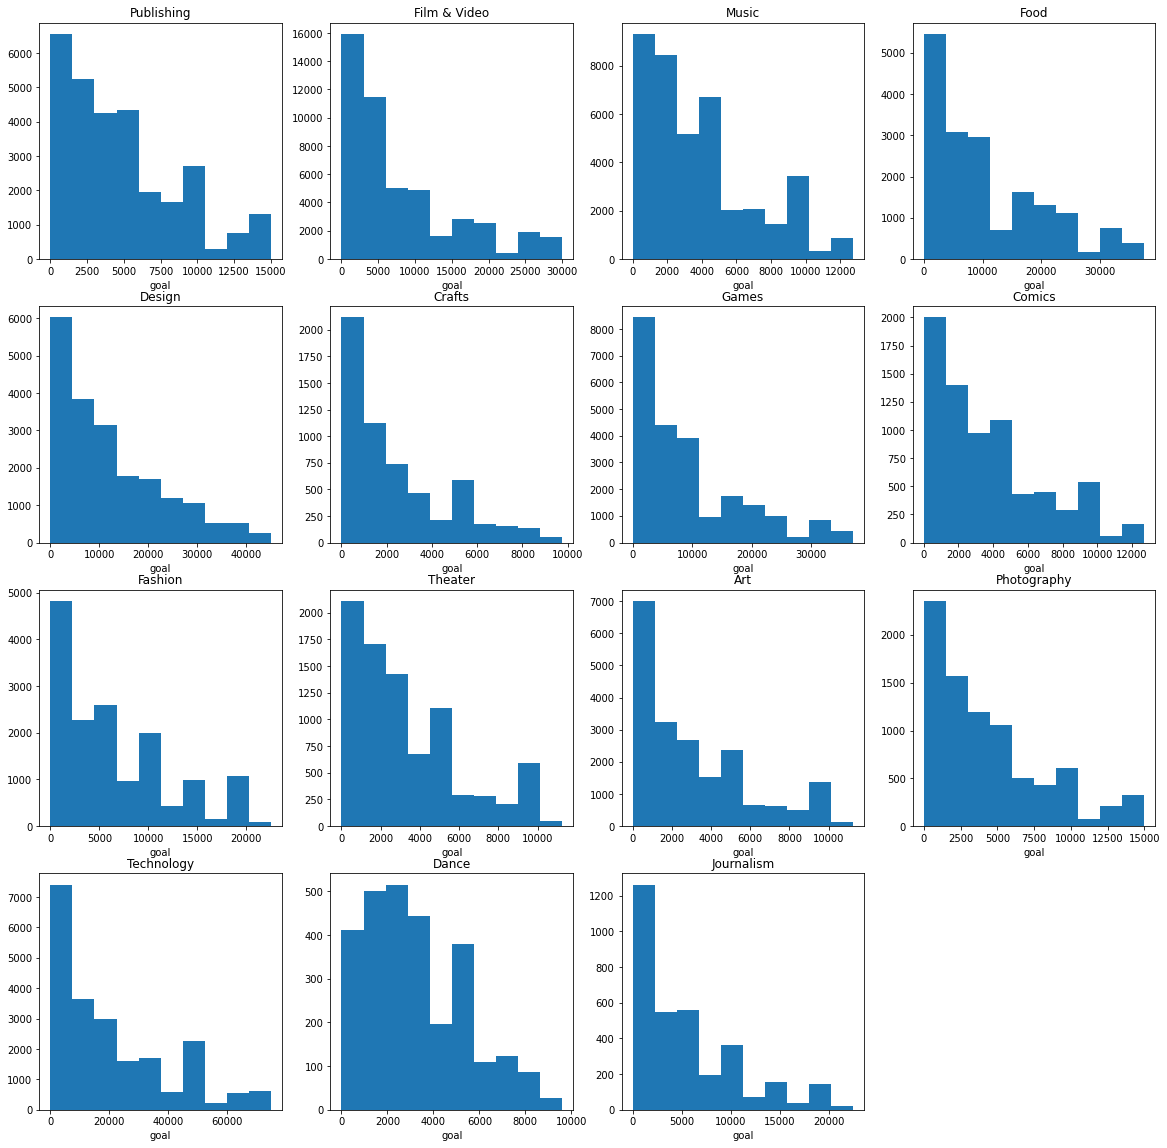

In [ ]:
cat_list = df['main_category'].unique()
plt.figure(figsize=(8,4))
fig = plt.figure(figsize=(20,20))
for i in range(df['main_category'].nunique()):
    ax = fig.add_subplot(4, 4, i+1)
    ax = plt.hist(df[df['main_category'] == cat_list[i]]['goal'],
                  bins=10,
                  range=(0,df[df['main_category'] == cat_list[i]]['goal'].quantile(0.75)*1.5))
    
    plt.title(cat_list[i])
    plt.xlabel('goal')

**Observation**: The distribution of each category showed that the data was right-skewed. Thus, it seemed a log transfromation of the this feature would be a way to resolve the outliers and right skewed distribution issues. 

<Figure size 576x288 with 0 Axes>

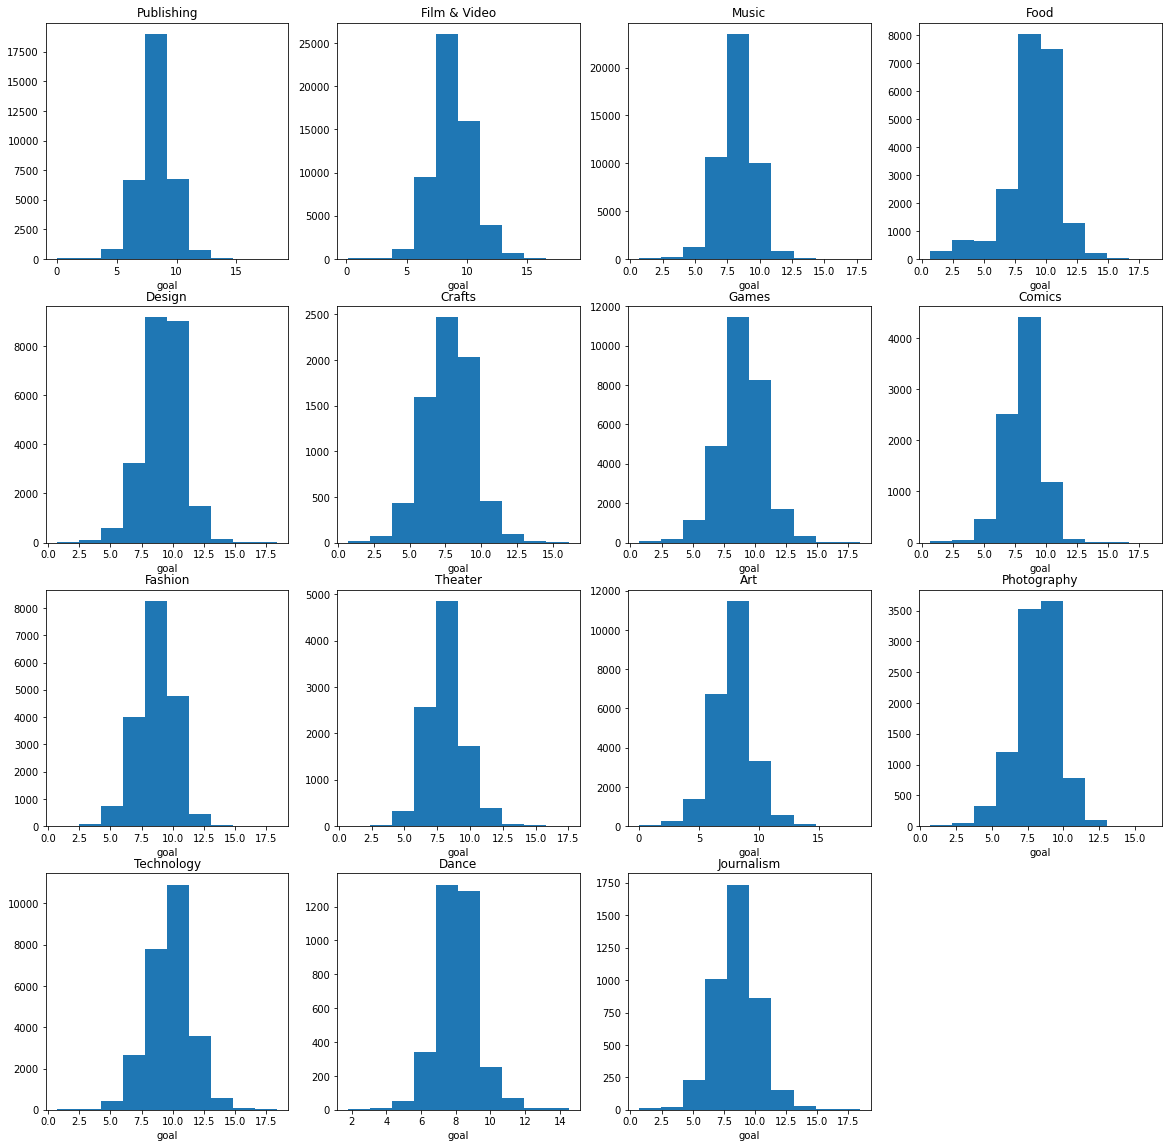

In [ ]:
df['log_goal'] = df['goal'].apply(lambda x: np.log1p(x))

plt.figure(figsize=(8,4))
fig = plt.figure(figsize=(20,20))
for i in range(df['main_category'].nunique()):
    ax = fig.add_subplot(4, 4, i+1)
    ax = plt.hist(df[df['main_category'] == cat_list[i]]['log_goal'],
                  bins=10)
    
    plt.title(cat_list[i])
    plt.xlabel('goal')

After performing the log transformation, the distributions were more normally distriubted

#### Sub-category

In [ ]:
for cat in df['main_category'].unique():
  print('main category: ', cat)
  print('')
  print('number of subcategory: ', df[df['main_category']==cat]['processed_sub_category'].nunique())
  print('')
  print('number of project in each sub-category: \n')
  print(df[df['main_category']==cat]['processed_sub_category'].value_counts())
  print('-----------------------------------')
  print('')

main category:  Publishing

number of subcategory:  15

number of project in each sub-category: 

Fiction              8231
Nonfiction           7404
Children's Books     5651
Publishing           5050
Art Books            2224
Poetry               1220
Periodicals          1142
Radio & Podcasts      802
Academic              706
Young Adult           652
Zines                 285
Anthologies           266
Calendars             243
Literary Journals     218
Translations          127
Name: processed_sub_category, dtype: int64
-----------------------------------

main category:  Film & Video

number of subcategory:  20

number of project in each sub-category: 

Documentary        14894
Shorts             11681
Film & Video        9207
Webseries           5347
Narrative Film      4963
Animation           2264
Comedy              1745
Drama               1719
Horror              1034
Television           822
Action               606
Science Fiction      602
Thrillers            597
Music V

**Observation**: Most main categories had distinct sub-categories. This would surely help classify the projects into their appropriate main categories because of their specificity. The only concern was for the Journalism category as its sub categories overlapped with other main categories, for instance, both Technology and Jounalism had a sub category called Web

#### Project Duration

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

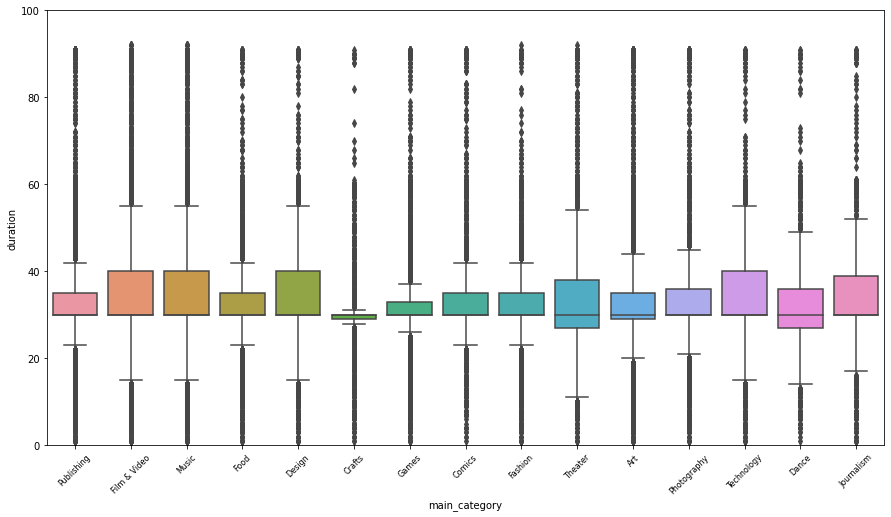

In [ ]:
fig= plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax = sns.boxplot(x='main_category',y='duration',data=df)
plt.ylim(0,100)
plt.xticks(fontsize=8,rotation=45)

**Observation**: Most categories shared the same patterns for the duration, so it might not be indicative to be one of the predictors

**Take away from Exploratory Analysis**

The quantitative features in the dataset did not seem to be effective to seperate main categories from each other, so using them as part of the predictors might not seem effective. On the other hand, the sub-category feature seemed to be the a helpful predictor because many of them were specific to their corresponding main category.  

## Modeling

This section consists of the best model demonstration, attempts of using various models and techniques, and a model hyperparameter tuning 

2 embeddig techniques were selected prior classification:

 - TFIDF: it was chosen because it is easy to compute and adjust the importance of word based on its occurance in all project titles

 - Word2Vec: it was chosen because it captures the position and meaning of the words in the project title 

4 models were chosen for classification: 

- Linear Support Vector Machine Classifier: it was chosen because it is effective in high dimensional space (even when # of features > # of samples) and it is versatile due to various kernels. 

- Naive Bayes Classifier: it was chosen because it is fast and highly scalable.

- Logistic Regression: it was chosen because it is easy to implement and the mechanism of it is slighly similar to nueral network (nueral network is somewhat a stacked logistic regression classifier)

- Random Forest Classifier: it is similar to decision tree but better at reducing variance


Side note:

For TFIDF vectorizer, the bigram feature was enabled. 

For all the benchmarking models, they were set with their default parameters except for Random Forest model (with max_depth = 100) to reduce training time.


In [3]:
#df.to_pickle('/content/gdrive/My Drive/Colab Notebooks/data/df.pkl')
#df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/data/df.pkl')

### Best results

In [28]:
df['processed_sub_category'] = df['processed_sub_category'].apply(lambda x: title_cleaning(x))

combined_text = df['processed_name'] + " " + df['processed_sub_category']
labels = df['main_category']

rus = RandomUnderSampler()

vectorizer = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer())
                       ])

time_vectorized_start = time.time()
vectorized_matrix = vectorizer.fit_transform(combined_text)
time_vectorized_end = time.time()

# resample the data
X_resampled, y_resampled = rus.fit_resample(vectorized_matrix,labels)

X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,
                                                 test_size=0.3,
                                                 random_state=123)


print('finished vectorization, the running time is: {}s'.format(np.round(time_vectorized_end-time_vectorized_start,2)))

results = []

classifier = LinearSVC()

print('begin training')
time_start = time.time()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

time_end = time.time()

report = classification_report(y_test, y_pred)
confusionMatrix = confusion_matrix(y_test,y_pred)
    

print('')
print('the training time is: {} s'.format(np.round(time_end-time_start,2)))
print('')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


finished vectorization, the running time is: 13.11s
begin training

the training time is: 2.71 s



In [29]:
print(report)

              precision    recall  f1-score   support

         Art       0.99      0.99      0.99       970
      Comics       0.99      0.99      0.99      1003
      Crafts       0.99      1.00      1.00       980
       Dance       0.97      1.00      0.98      1001
      Design       1.00      0.99      0.99      1007
     Fashion       0.99      0.99      0.99      1004
Film & Video       0.99      0.98      0.98      1063
        Food       0.98      0.99      0.99       997
       Games       1.00      1.00      1.00      1044
  Journalism       0.91      0.96      0.93      1019
       Music       0.99      0.99      0.99      1010
 Photography       0.99      0.99      0.99      1054
  Publishing       0.99      0.99      0.99      1001
  Technology       0.98      0.89      0.93      1001
     Theater       0.98      0.98      0.98      1020

    accuracy                           0.98     15174
   macro avg       0.98      0.98      0.98     15174
weighted avg       0.98   

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

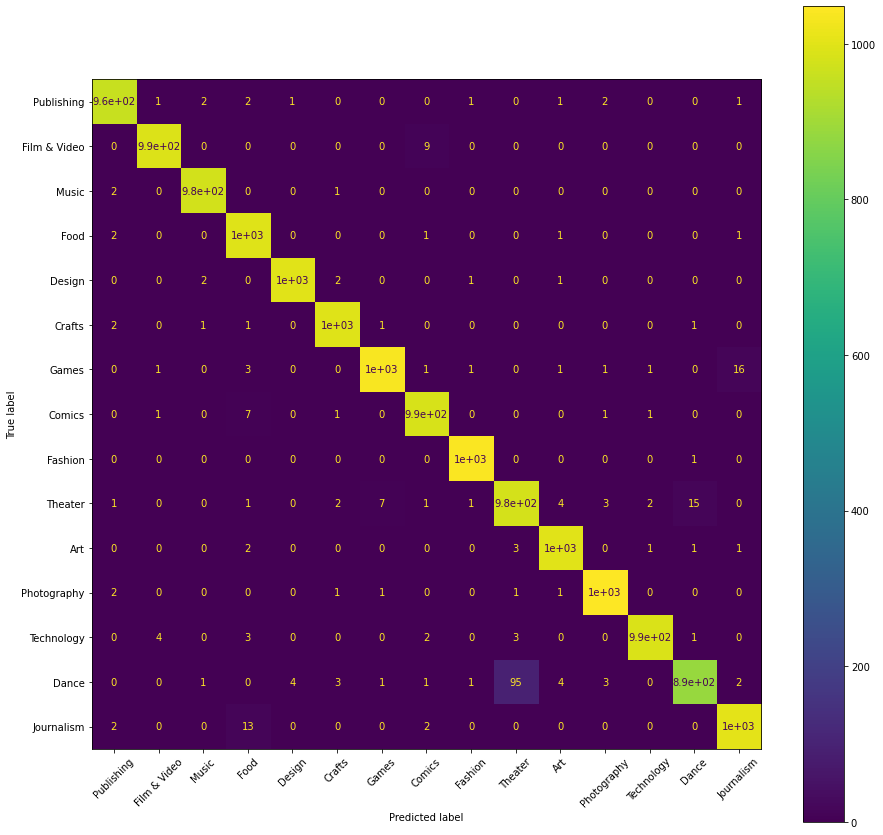

In [41]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay(confusionMatrix,display_labels=labels.unique()).plot(ax=ax)
plt.xticks(rotation=45)

**Observation**: All categories were classifed near perfectly, with only a handful (< 10) was mis-classified. The poorest performance was in Theater and Dance categories, where 95 samples of Theater catorgory were wrongly identified as Dance category  

#### Benchmarking with TFIDF vectorizer 

In [7]:
# using project names as predictor 
project_names = df['processed_name']
labels = df['main_category']

X_train, X_test, y_train, y_test = train_test_split(project_names, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state = 123)
# initiate a pipeline for vectorization 
vectorizer = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer())
                       ])

time_vectorized_start = time.time()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
time_vectorized_end = time.time()

print('finished vectorization, the running time is: {}s'.format(np.round(time_vectorized_end-time_vectorized_start,2)))

finished vectorization, the running time is: 8.75s


In [9]:
results = []

clf_models = {
    "SVC": LinearSVC(),
    "NB": MultinomialNB(),
    "LR": LogisticRegression(multi_class='multinomial'),
    "RF": RandomForestClassifier(max_depth=100)
}

# iterate each model to perform benchmarking
for mdl_name in clf_models.keys():
    print('begin training {}'.format(mdl_name))
    time_start = time.time()

    classifier = clf_models[mdl_name]
  
    classifier.fit(X_train_vectorized, y_train)

    y_pred = classifier.predict(X_test_vectorized)
    time_end = time.time()

    report = classification_report(y_test, y_pred)
    results.append((mdl_name,report))

    print('finished training ',mdl_name)
    print('')
    print('the training time is: {} s'.format(np.round(time_end-time_start,2)))
    print('')

begin training SVC
finished training  SVC

the training time is: 42.1 s

begin training NB


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training  NB

the training time is: 1.81 s

begin training LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finished training  LR

the training time is: 271.65 s

begin training RF


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training  RF

the training time is: 644.16 s



In [10]:
for i in range(len(results)):
  print('model name: ', results[i][0])
  print('')
  print(results[i][1])
  print('')

model name:  SVC

              precision    recall  f1-score   support

         Art       0.54      0.47      0.50      7145
      Comics       0.70      0.53      0.60      2637
      Crafts       0.52      0.36      0.43      2129
       Dance       0.68      0.47      0.55      1035
      Design       0.55      0.51      0.53      7214
     Fashion       0.68      0.67      0.68      5481
Film & Video       0.53      0.66      0.59     17406
        Food       0.74      0.82      0.78      6425
       Games       0.68      0.65      0.67      8352
  Journalism       0.29      0.10      0.15      1242
       Music       0.76      0.79      0.77     14032
 Photography       0.54      0.44      0.49      2902
  Publishing       0.53      0.53      0.53     10125
  Technology       0.60      0.57      0.59      7769
     Theater       0.62      0.50      0.55      3043

    accuracy                           0.61     96937
   macro avg       0.60      0.54      0.56     96937
weighted

**Observation:**

Among these 4 benchmarking models, LinearSVC and Logistic Regression had similar performance, where both of them had  balanced results of precision and recall, and therefore highest overall accuracy. Since LinearSVC had a much faster processing time than Logistic Regression under this condition, I would suggest LinearSVC is a better model than Logistic Regression

For Naive Bayes model, it had the fastest processing time and the second highest overall precesion, but it was unable to recall several categories (those with relatively fewer samples). 

For the Random Forest, it had the longest running time (only because it reached the maximum depth, otherwise it would keep running). It had the highest precision but lowest recall rate, leading to the poorest performance among all models. Nonetheless, with some hyerparameter tuning, its performance would be expected to improve.

Overall, all models suffer the effect of class imbalance. They could not recognize the patterns of the categories with relatively fewer samples. To resolve this issue, a undersampling could be applied to the dataset.  

#### Benchmarking with Word2Vec

In [26]:
# tokanize the project title names
project_names = df['processed_name'].apply(lambda x: word_tokenize(x))

labels = df['main_category']

# fit the Word2Vec model with the tokanized project title names
w2v_model = Word2Vec(project_names,sg=1)

# create the Word2Vec dictionary
w2v_dict = {w: vec for w, vec in zip(w2v_model.wv.index2word, 
                                     w2v_model.wv.syn0)}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


In [27]:
# define a Word2Vec vectorizer class
class w2v_Vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v_dict))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
                         np.mean([self.word2vec[word] for word in words if word in self.word2vec]
                                 or [np.zeros(self.dim)], axis=0)
                         for words in X
                         ])

In [28]:
# Define a pipeline to chain Word2Vec vectorizer and classifier
LR_w2v = Pipeline([("word2vec", W2V_Vectorizer(w2v_dict)),("lr", LogisticRegression(multi_class='multinomial'))])
RF_w2v = Pipeline([("word2vec", W2V_Vectorizer(w2v_dict)),("rf", RandomForestClassifier(max_depth=100))])

clf_models = {
    "LR": LR_w2v,
    "RF": RF_w2v 
}

In [29]:
X_train, X_test, y_train, y_test = train_test_split(project_names, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state = 123)
results =[]

for mdl_name in clf_models.keys():
    print('begin training {}'.format(mdl_name))
    time_start = time.time()

    classifier = clf_models[mdl_name]
  
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    time_end = time.time()

    report = classification_report(y_test, y_pred)
    results.append((mdl_name,report))

    print('finished training ',mdl_name)
    print('')
    print('the training time is: {} s'.format(np.round(time_end-time_start,2)))
    print('')

begin training LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finished training  LR

the training time is: 47.84 s

begin training RF
finished training  RF

the training time is: 450.66 s



In [30]:
for i in range(len(results)):
  print('model name: ', results[i][0])
  print('')
  print(results[i][1])
  print('')

model name:  LR

              precision    recall  f1-score   support

         Art       0.49      0.41      0.44      7145
      Comics       0.60      0.36      0.45      2637
      Crafts       0.50      0.20      0.29      2129
       Dance       0.76      0.28      0.41      1035
      Design       0.49      0.43      0.46      7214
     Fashion       0.63      0.56      0.60      5481
Film & Video       0.44      0.69      0.54     17406
        Food       0.69      0.74      0.71      6425
       Games       0.65      0.58      0.61      8352
  Journalism       0.46      0.02      0.04      1242
       Music       0.71      0.76      0.74     14032
 Photography       0.56      0.29      0.38      2902
  Publishing       0.49      0.45      0.47     10125
  Technology       0.54      0.52      0.53      7769
     Theater       0.59      0.34      0.44      3043

    accuracy                           0.55     96937
   macro avg       0.57      0.44      0.47     96937
weighted 

**Observation**:

For word2vec vectorizer, only Logistic Regression and Random Forest were selected because the execution time for LinearSVC was too long and Naive Bayer could not handle negative vector values. 

Both models had very similar performance. Comparing TFIDF and Word2Vec, Logistic Regression would be better suited with TFIDF, whereas Random Forest would be better suited with Word2Vec 

#### Using name & sub category as predictors

To incorporate sub categories into the predictors, two methods were considered. 

1. combining the project title names and sub category together as a list of tokenized words

2. transforming each sub category into a dummy categorical feature

After trying both methods, method 1 was a selected because method 2 required too much memory, as the predictors would consist of too many columns. 

If method 2 were to be implemented, it would require dimensioanlity reduction using PCA/SVD. However, the running time would still be long

In [16]:
df['processed_sub_category'] = df['processed_sub_category'].apply(lambda x: title_cleaning(x))

text = df['processed_name'] + " " + df['processed_sub_category']

X_train, X_test, y_train, y_test = train_test_split(text, labels, 
                                                    test_size=0.3, 
                                                    random_state = 123)

vectorizer = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer())
                       ])
time_vectorized_start = time.time()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
time_vectorized_end = time.time()

print('finished vectorization, the running time is: {}s'.format(np.round(time_vectorized_end-time_vectorized_start,2)))

finished vectorization, the running time is: 9.8s


In [17]:
results = []

clf_models = {
    "SVC": LinearSVC(),
    "NB": MultinomialNB(),
    "LR": LogisticRegression(multi_class='multinomial'),
    "RF": RandomForestClassifier(max_depth=100)
}

for mdl_name in clf_models.keys():
    print('begin training {}'.format(mdl_name))
    time_start = time.time()

    classifier = clf_models[mdl_name]
  
    classifier.fit(X_train_vectorized, y_train)

    y_pred = classifier.predict(X_test_vectorized)
    time_end = time.time()

    report = classification_report(y_test, y_pred)
    results.append((mdl_name,report))

    print('finished training ',mdl_name)
    print('')
    print('the training time is: {} s'.format(np.round(time_end-time_start,2)))
    print('')

begin training SVC
finished training  SVC

the training time is: 29.32 s

begin training NB
finished training  NB

the training time is: 1.68 s

begin training LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finished training  LR

the training time is: 300.66 s

begin training RF


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training  RF

the training time is: 348.24 s



In [18]:
for i in range(len(results)):
  print('model name: ', results[i][0])
  print('')
  print(results[i][1])
  print('')

model name:  SVC

              precision    recall  f1-score   support

         Art       0.83      0.81      0.82      7145
      Comics       0.93      0.71      0.81      2637
      Crafts       0.76      0.57      0.65      2129
       Dance       0.88      0.62      0.73      1035
      Design       0.96      0.90      0.93      7214
     Fashion       0.85      0.79      0.82      5481
Film & Video       0.73      0.88      0.80     17406
        Food       0.85      0.89      0.87      6425
       Games       0.98      0.95      0.97      8352
  Journalism       0.75      0.33      0.46      1242
       Music       0.90      0.92      0.91     14032
 Photography       0.83      0.65      0.73      2902
  Publishing       0.78      0.80      0.79     10125
  Technology       0.76      0.76      0.76      7769
     Theater       0.81      0.68      0.74      3043

    accuracy                           0.83     96937
   macro avg       0.84      0.75      0.79     96937
weighted

**Observation**:

Combining sub category with the project names drastically improved the precision score for all models. This was mainly because many sub categories were very specific to their main categories. The models also had higher recall score, but the increase was not as high as the precision. However, adding sub category still could not completely solve the class imbalance problem.   

#### Undersampling

To address the class imabalance problem, the random undersampling method was used. The mechanism of random undersampling was to select a sample size equivalent to the size of fthe fewest category 

In [23]:
# initiate the random under sampler 
rus = RandomUnderSampler()

project_names = df['processed_name']
labels = df['main_category']

# vectorize the project names
vectorizer = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer())
                       ])
time_vectorized_start = time.time()
vectorized_matrix = vectorizer.fit_transform(project_names)
time_vectorized_end = time.time()

# resample the data
X_resampled, y_resampled = rus.fit_resample(vectorized_matrix,labels)

X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,
                                                 test_size=0.3,
                                                 random_state=123)


print('finished vectorization, the running time is: {}s'.format(np.round(time_vectorized_end-time_vectorized_start,2)))

finished vectorization, the running time is: 9.38s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [27]:
results = []

clf_models = {
    "SVC": LinearSVC(),
    "NB": MultinomialNB(),
    "LR": LogisticRegression(multi_class='multinomial'),
    "RF": RandomForestClassifier(max_depth=100)
}

for mdl_name in clf_models.keys():
    print('begin training {}'.format(mdl_name))
    time_start = time.time()

    classifier = clf_models[mdl_name]
  
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    time_end = time.time()

    report = classification_report(y_test, y_pred)
    results.append((mdl_name,report))

    print('finished training ',mdl_name)
    print('')
    print('the training time is: {} s'.format(np.round(time_end-time_start,2)))
    print('')

begin training SVC
finished training  SVC

the training time is: 4.07 s

begin training NB
finished training  NB

the training time is: 0.54 s

begin training LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finished training  LR

the training time is: 229.53 s

begin training RF
finished training  RF

the training time is: 518.34 s



In [28]:
for i in range(len(results)):
  print('model name: ', results[i][0])
  print('')
  print(results[i][1])
  print('')

model name:  SVC

              precision    recall  f1-score   support

         Art       0.43      0.39      0.41       970
      Comics       0.64      0.59      0.61      1003
      Crafts       0.51      0.50      0.51       980
       Dance       0.67      0.61      0.63      1001
      Design       0.45      0.39      0.42      1007
     Fashion       0.65      0.63      0.64      1004
Film & Video       0.46      0.41      0.43      1063
        Food       0.67      0.75      0.71       997
       Games       0.59      0.55      0.57      1044
  Journalism       0.41      0.38      0.39      1019
       Music       0.70      0.68      0.69      1010
 Photography       0.52      0.52      0.52      1054
  Publishing       0.36      0.34      0.35      1001
  Technology       0.35      0.56      0.43      1001
     Theater       0.53      0.54      0.54      1020

    accuracy                           0.52     15174
   macro avg       0.53      0.52      0.52     15174
weighted

**Observation**:

Although the overall performance decreased for all model after resampling, the individual results improved for those categories with fewer samples previously. All four models showed good agreement in their performances.  

### Name & sub category + Undersampling

#### method 1

In [36]:
df['processed_sub_category'] = df['processed_sub_category'].apply(lambda x: title_cleaning(x))

combined_text = df['processed_name'] + " " + df['processed_sub_category']
labels = df['main_category']

rus = RandomUnderSampler()

vectorizer = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer())
                       ])
time_vectorized_start = time.time()
vectorized_matrix = vectorizer.fit_transform(combined_text)
time_vectorized_end = time.time()

# resample the data
X_resampled, y_resampled = rus.fit_resample(vectorized_matrix,labels)

X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,
                                                 test_size=0.3,
                                                 random_state=123)


print('finished vectorization, the running time is: {}s'.format(np.round(time_vectorized_end-time_vectorized_start,2)))

results = []

clf_models = {
    "SVC": LinearSVC(),
    "NB": MultinomialNB(),
    "LR": LogisticRegression(multi_class='multinomial'),
    "RF": RandomForestClassifier(max_depth=100)
}

for mdl_name in clf_models.keys():
    print('begin training {}'.format(mdl_name))
    time_start = time.time()

    classifier = clf_models[mdl_name]
  
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    time_end = time.time()

    report = classification_report(y_test, y_pred)
    results.append((mdl_name,report))

    print('finished training ',mdl_name)
    print('')
    print('the training time is: {} s'.format(np.round(time_end-time_start,2)))
    print('')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


finished vectorization, the running time is: 9.16s
begin training SVC
finished training  SVC

the training time is: 1.7 s

begin training NB
finished training  NB

the training time is: 0.67 s

begin training LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finished training  LR

the training time is: 279.85 s

begin training RF
finished training  RF

the training time is: 233.25 s



In [37]:
for i in range(len(results)):
  print('model name: ', results[i][0])
  print('')
  print(results[i][1])
  print('')

model name:  SVC

              precision    recall  f1-score   support

         Art       0.99      0.99      0.99       970
      Comics       0.99      0.99      0.99      1003
      Crafts       0.99      0.99      0.99       980
       Dance       0.97      1.00      0.98      1001
      Design       1.00      1.00      1.00      1007
     Fashion       0.99      1.00      0.99      1004
Film & Video       0.99      0.98      0.99      1063
        Food       0.98      0.99      0.99       997
       Games       1.00      1.00      1.00      1044
  Journalism       0.92      0.97      0.95      1019
       Music       0.99      0.99      0.99      1010
 Photography       0.99      0.99      0.99      1054
  Publishing       0.99      0.98      0.99      1001
  Technology       0.98      0.92      0.95      1001
     Theater       0.98      0.98      0.98      1020

    accuracy                           0.98     15174
   macro avg       0.98      0.98      0.98     15174
weighted

**Observation**:

With undersampling, the class imbalance issue was resolved, so all categories had equal amount of samples to be characterized by all models. In addition to the specificity effect provided by the sub category, all models delievered almost perfect performance 

### Numeric features

In [110]:

df['name_is_question'] = df['name_is_question'].map({True:1,False:0})
df['name_is_question'].fillna(0,inplace=True)

numeric_features = df[['log_goal','duration','num_word','num_1st_letter_uppercase','num_capword']]
is_question_col = pd.DataFrame.sparse.from_spmatrix(OneHotEncoder().fit_transform(df['name_is_question'].values.reshape(-1,1))).iloc[:,1]

In [114]:
scaler = MinMaxScaler()
numeric_features_sc = pd.DataFrame(scaler.fit_transform(numeric_features),columns=numeric_features.columns)

features = pd.concat([numeric_features_sc,is_question_col],axis=1)
labels = df['main_category']

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state = 123)

results = []

clf_models = {
    "SVC": LinearSVC(),
    "NB": MultinomialNB(),
    "LR": LogisticRegression(multi_class='multinomial'),
    "RF": RandomForestClassifier(max_depth=100)
}

for mdl_name in clf_models.keys():
    print('begin training {}'.format(mdl_name))
    time_start = time.time()

    classifier = clf_models[mdl_name]
  
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    time_end = time.time()

    report = classification_report(y_test, y_pred)
    results.append((mdl_name,report))

    print('finished training ',mdl_name)
    print('')
    print('the training time is: {} s'.format(np.round(time_end-time_start,2)))
    print('')

begin training SVC


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training  SVC

the training time is: 74.3 s

begin training NB


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training  NB

the training time is: 1.35 s

begin training LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training  LR

the training time is: 32.29 s

begin training RF
finished training  RF

the training time is: 46.52 s



In [115]:
for i in range(len(results)):
  print('model name: ', results[i][0])
  print('')
  print(results[i][1])
  print('')

model name:  SVC

              precision    recall  f1-score   support

         Art       0.00      0.00      0.00      7145
      Comics       0.00      0.00      0.00      2637
      Crafts       0.00      0.00      0.00      2129
       Dance       0.00      0.00      0.00      1035
      Design       0.00      0.00      0.00      7214
     Fashion       0.00      0.00      0.00      5481
Film & Video       0.21      0.71      0.32     17406
        Food       0.00      0.00      0.00      6425
       Games       0.00      0.00      0.00      8352
  Journalism       0.00      0.00      0.00      1242
       Music       0.20      0.48      0.28     14032
 Photography       0.00      0.00      0.00      2902
  Publishing       0.09      0.00      0.00     10125
  Technology       0.26      0.10      0.14      7769
     Theater       0.00      0.00      0.00      3043

    accuracy                           0.21     96937
   macro avg       0.05      0.09      0.05     96937
weighted

**Observation**:

Only using the numeric features proved to be ineffective because almost all categories processed simialr numeric patterns. Only the characteristic of Film & Video was able to be identified by the models, though the results were still very poor. In short, numeric features did not seem to be helpful 

### GridSearch

The grid search was taking a much long time than expected, so I was not able to complete the process due to time limitation. But the following codes were able to run succesfully, so it would eventually yield the best parameters for Logistic Regression. 

Tuning of Logistic Regression

In [19]:
rus = RandomUnderSampler()

project_names = df['processed_name']
labels = df['main_category']

# vectorize the project names
vectorizer = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer())
                       ])

In [45]:
time_vectorized_start = time.time()
vectorized_matrix = vectorizer.fit_transform(project_names)
time_vectorized_end = time.time()

# resample the data
X_resampled, y_resampled = rus.fit_resample(vectorized_matrix,labels)

X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,
                                                 test_size=0.3,
                                                 random_state=123)


print('finished vectorization, the running time is: {}s'.format(np.round(time_vectorized_end-time_vectorized_start,2)))

finished vectorization, the running time is: 11.1s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
parameters = {
    'max_iter': (100,150,180),
    'C': (0.01,1, 10)
}

classifier = LogisticRegression()


random_search =RandomizedSearchCV(classifier, parameters, cv=3, n_jobs=-1)

time_start = time.time()
print('Begin grid searching')
print('')
random_search.fit(X_train, y_train)

time_end = time.time()

print('finished grid searching, the running time is: {}s'.format(np.round(time_end-time_start,2)))
print('')
print("Best parameters set:")
best_parameters = random_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
random_search.cv_results_

In [ ]:
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

## Conclusion 

1. it was found that the name of projects and their corresponding subcategories were sufficient enough to classify the main category of projects. 

2. the numeric features of project names, goal of projects, and project duration did not have high influence in determining the main category of projects.  

3. it could be argued that using subcategories as one of the predictors somewhat defeated the purpose of classifying the main cateogries, because subcategories typically come after main category being selected. 

4. Between TFIDF and Word2Vec, they both had similar performance. TFIDF worked seamlessly with all models whereas Word2Vec only worked well with Logistic Regression and Random Forest (Word2Vec could also work with SVC but the execution time would be very long). 

5. For the models who could work well with both embedding techniques, Logistic Regression was better suited with TFIDF and Random Forest was better with Word2Vec

6. Among all models, LinearSVC and Logistic Regression had similar performance but LinearSVC had a mush shorter computation time. Although Naive Bayes had the fastest speed, it did not perform as well as the aforementioned two models. Random Forest required the longest time to train due to the high number of textual features in the dataset. 

7. Undersampling was shown to be effective to resolve the class imbalance issue

Future work:

1. Trying dimensionality reduction technique such as SVD. In fact, I attempted to incorporate a truncatedSVD but the session ran out of memory several times. 

2. Adjusting the parameters of TFIDF and Word2Vec to reduce the memory usage while maintain the performance. I did not set a maximum features for both TFIDF and Word2Vec, resulting a large predicting matirx/dictionary.  

3. Trying other embedding techniques. Project names are typically unique such that there are many rare words. The meaning of the name would intuitively be more important than the frequency of words, so using embedding technqiues that capture the position of words would be helpful. 